In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
should_skip = True

In [6]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0.dev20220327+cu113 requires torch==1.12.0.dev20220327+cu113, but you have torch 2.1.0 which is incompatible.
torchaudio 0.12.0.dev20220327+cu113 requires torch==1.12.0.dev20220327, but you have torch 2.1.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [7]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [8]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
To: /root/slime-experiments/my_concept_gt.zip
100%|██████████████████████████████████████| 14.7k/14.7k [00:00<00:00, 37.6MB/s]
Archive:  my_concept_gt.zip
  inflating: my_concept_gt/1.png     
  inflating: my_concept_gt/0.png     


In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

/content


In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [9]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

OSError: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory

In [9]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=5_000,
    batch_size=1
)

In [10]:
slime = SLiME(
    use_self_attn=False,
    alpha=0.0,
    # cross_attn_nums=[8],
    multiplier_lr=0.05,
    lr=0.05,
).cuda()

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [11]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=50,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 10    
2 | self_layer_multiplier  | Multiplier      | 6     
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_multiplier    | Multiplier      | 4     
5 | cross_norm      

Training: |          | 0/? [00:00<?, ?it/s]

tensor(24.7742, device='cuda:0', grad_fn=<MeanBackward0>)
pred 123.14949798583984 124.3951416015625 ce loss 89.26510620117188 mse loss 0.720458984375 

tensor(26.4167, device='cuda:0', grad_fn=<MeanBackward0>)
pred 58.35050582885742 69.23954772949219 ce loss 37.701663970947266 mse loss 0.607666015625 

tensor(30.2052, device='cuda:0', grad_fn=<MeanBackward0>)
pred 24.526079177856445 38.615272521972656 ce loss 22.244361877441406 mse loss 0.720458984375 

tensor(34.3910, device='cuda:0', grad_fn=<MeanBackward0>)
pred 11.441424369812012 24.5760498046875 ce loss 8.587602615356445 mse loss 0.6076642274856567 

tensor(37.9381, device='cuda:0', grad_fn=<MeanBackward0>)
pred 4.87029504776001 11.684255599975586 ce loss 4.017539978027344 mse loss 0.6052646636962891 

tensor(40.8800, device='cuda:0', grad_fn=<MeanBackward0>)
pred 1.0618776082992554 6.385252952575684 ce loss 2.0918729305267334 mse loss 0.6275350451469421 

tensor(43.1806, device='cuda:0', grad_fn=<MeanBackward0>)
pred -0.310153722

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [12]:
slime.cuda(); 1

1

In [13]:
slime.cross_layer_multiplier.weight.data

tensor([-0.4814, -0.4656, -0.4499, -0.4085, -0.4370], device='cuda:0')

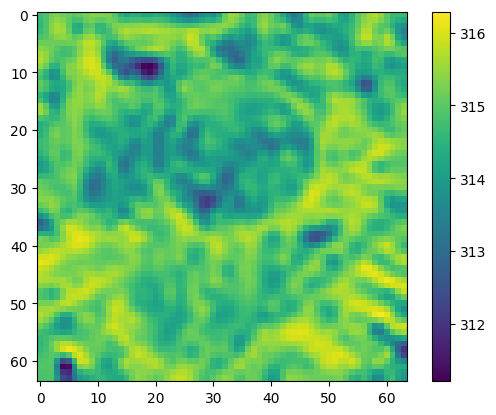

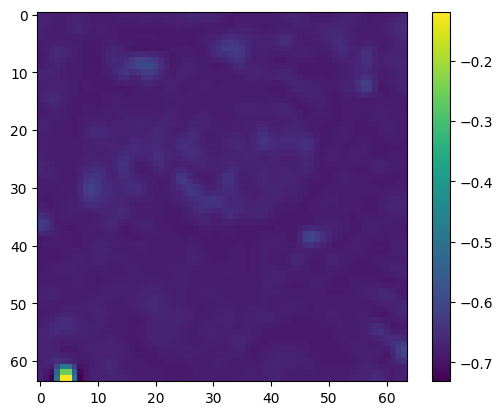

In [14]:
import matplotlib.pyplot as plt
sigmoid = lambda x: np.exp(-x) / (1 + np.exp(-x))
for i in range(slime.text_tokens):
  plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,i])
  plt.colorbar()
  plt.show()

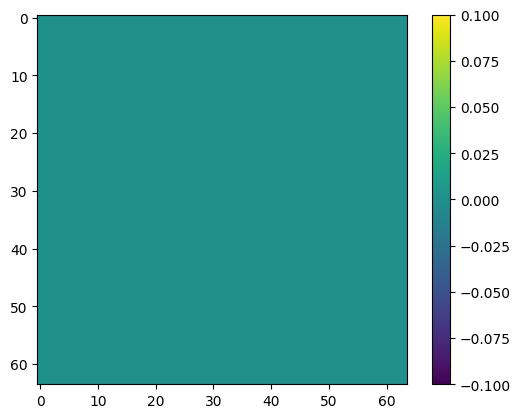

In [15]:
naive_map = slime.latest_preds[-1].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1] > 0
# naive_map = (naive_map-naive_map.min())/(naive_map.max()-naive_map.min())
plt.imshow(naive_map)
plt.colorbar()

tensor(49.4351, device='cuda:0')


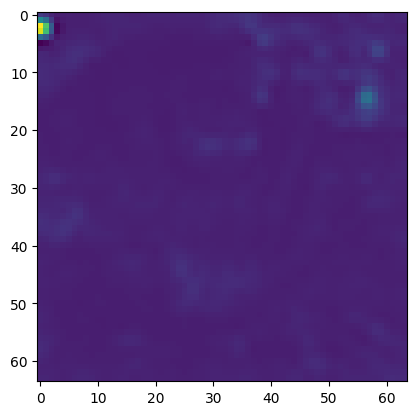

In [16]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  break

import matplotlib.pyplot as plt
for i in range(len(out_mask)):
  plt.imshow(out_mask[i,:,1].reshape((64,64)))
  plt.show()

In [17]:
!cd /content/slime-experiments/ && git diff

diff --git a/slime/data/single_class.py b/slime/data/single_class.py
index 2f82aff..b10a2f5 100644
--- a/slime/data/single_class.py
+++ b/slime/data/single_class.py
@@ -85,12 +85,14 @@ class SegmentationDataModule(L.LightningDataModule):
         self,
         train_dataset: Dataset,
         test_dataset: Dataset=None,
-        iters_per_epoch:int=50
+        iters_per_epoch:int=50,
+        batch_size:int=2,
     ):
         super().__init__()
         self.train_dataset = train_dataset
         self.test_dataset = test_dataset
         self.iters_per_epoch = iters_per_epoch
+        self.batch_size = batch_size
     
     def cycle(self,iterable,max_iters):
       iters = 0
diff --git a/slime/multiplier.py b/slime/multiplier.py
index 74eb960..4dadf79 100644
--- a/slime/multiplier.py
+++ b/slime/multiplier.py
@@ -8,4 +8,5 @@ class Multiplier(nn.Module):
     self.bias = nn.Parameter(torch.zeros(size))
 
   def forward(self, x):
-    return x * self.weight + self.bias
\ No newline at